# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/gauravdesai/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/gauravdesai/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
remove_metadata=('headers', 'footers', 'quotes')
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=remove_metadata,
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=remove_metadata,
                                     categories=categories)

num_test = len(newsgroups_test.target)

test_data, test_labels = newsgroups_test.data[num_test//2:], newsgroups_test.target[num_test//2:]
dev_data, dev_labels = newsgroups_test.data[:num_test//2], newsgroups_test.target[:num_test//2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
def printMessages(data, labels, messages_to_print=5):
    """
    Prints first n messages from data along with the label of message.
    where n i.e. number of messages to print is specified by argument examples_to_print
    
    Args:
        data (list): messages data list from which messages to be printed
        labels (numpy.ndarray): labels corresponding to data list. 
        
    Kwargs:
        messages_to_print (int): number of messages to print from data
        
    Returns:
        None, Does not return anything
    """
    print("Here are the first {} training examples".format(messages_to_print))
    print('-'*80)
    print()
    for index in range(messages_to_print):
        print('{}]\nLabel  :::{}\nMessage:::\n\n{}\n\n'.format(
            index+1,
            newsgroups_train.target_names[labels[index]],
            data[index]))
        print('-'*80)

printMessages(train_data, train_labels, 5)

Here are the first 5 training examples
--------------------------------------------------------------------------------

1]
Label  :::comp.graphics
Message:::

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


--------------------------------------------------------------------------------
2]
Label  :::talk.religion.misc
Message:::



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who tho

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

In [4]:
print('a.')
print('Fitting and Transforming training data using CountVectorizer')
vec = CountVectorizer()
X=vec.fit_transform(train_data)

print('Size of vocabulary={}'.format(X.shape[1]))
print('Average number of non zero features per examples={0:.5f}'
      .format(X.nnz/(X.shape[0])))
print('% of non zero entries in Matrix={0:.5f}'
      .format(100*X.nnz/(X.shape[0]*X.shape[1])))

a.
Fitting and Transforming training data using CountVectorizer
Size of vocabulary=26879
Average number of non zero features per examples=96.70600
% of non zero entries in Matrix=0.35978


In [5]:
print('b.')
featureNamesSorted=sorted(vec.get_feature_names())
print('0th and last feature string after sorting is {} and {} respectively'
      .format(featureNamesSorted[0],featureNamesSorted[-1]))

b.
0th and last feature string after sorting is 00 and zyxel respectively


In [6]:
print('c.')
custom_vocab = ["atheism", "graphics", "space", "religion"]
vec = CountVectorizer(vocabulary=custom_vocab)
X=vec.fit_transform(train_data)

print('Training Matrix Size={} by {}'.format(X.shape[0],X.shape[1]))
print('Feature size matches with custom vocabulary size?:{}'
      .format(X.shape[1]==len(custom_vocab)))
print('Now average number of non zero features per examples={0:.5f}\n'
      .format(X.nnz/(X.shape[0])))

c.
Training Matrix Size=2034 by 4
Feature size matches with custom vocabulary size?:True
Now average number of non zero features per examples=0.26844



In [7]:
print('d.')
vec = CountVectorizer(analyzer='char_wb', ngram_range=(2,3))
X=vec.fit_transform(train_data)
print('Size of vocabulary with bigrams and trigrams character features={}'
      .format(X.shape[1]))

d.
Size of vocabulary with bigrams and trigrams character features=28954


In [8]:
print('e.')
min_df=10
vec = CountVectorizer(min_df=min_df)
X=vec.fit_transform(train_data)
print('Size of vocabulary after pruning features present in less than {} documents={}'
      .format(min_df,X.shape[1]))

e.
Size of vocabulary after pruning features present in less than 10 documents=3064


In [9]:
print('f.')
vecTrain = CountVectorizer()
XTrain=vecTrain.fit_transform(train_data)
trainFeatureNames = vecTrain.get_feature_names()

vecDev = CountVectorizer()
XDev=vecDev.fit_transform(dev_data)
devFeatureNames = vecDev.get_feature_names()

diff = set(devFeatureNames) - set(trainFeatureNames)
print('{} words are present in Dev data vocabulary vs {} present in Training data vocabulary'
      .format(XDev.shape[1],XTrain.shape[1]))
print('{0:.2f}% of words present in Dev data are missing in Training data vocabulary'
      .format(100 * len(diff)/len(devFeatureNames)))

f.
16246 words are present in Dev data vocabulary vs 26879 present in Training data vocabulary
24.79% of words present in Dev data are missing in Training data vocabulary


(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

In [10]:
# Vectorizing Training Data 
vecTrain = CountVectorizer()
XTrain=vecTrain.fit_transform(train_data)

In [11]:
# Create KNN Classifier
def getKNNClassifier():
    classifier =  {
        'prameter_name' : 'n_neighbors',
        'parameters' : {
            'n_neighbors' : list(range(1,200,2))
        },
        'name' : 'KNN Classifier',
        'clf' : KNeighborsClassifier(),
        'prameter_name_to_print' : 'K'
    }
    
    return classifier

In [12]:
# Create Multinomial Naive Bayes Classifier
def getMNBClassifier():
    classifier =  {
        'prameter_name' : 'alpha',
        'parameters' : {
            'alpha' : np.arange(0.0001,0.1,0.0005)
        },
        'name' : 'Multinomial Naive Bayes Classifier',
        'clf' : MultinomialNB(),
        'prameter_name_to_print' : 'Alpha'
    }
    
    return classifier

In [13]:
# Create Logistic Regression
def getLogisticRegression():
    classifier =  {
        'prameter_name' : 'C',
        'parameters' : {
            'C' : np.arange(0.01,0.3,0.01)
        },
        'name' : 'Logistic Regression',
        'clf' : LogisticRegression(penalty='l2'),
        'prameter_name_to_print' : 'C'
    }
    
    return classifier

In [14]:
classifiers = (getKNNClassifier(),getMNBClassifier(),getLogisticRegression())
for classifier in classifiers:
    print('Using {}'.format(classifier['name']))
    grid_search = GridSearchCV(classifier['clf']
                               ,param_grid=classifier['parameters']
                               ,scoring='f1_weighted',n_jobs=-1)
    grid_search.fit(XTrain, train_labels)
    print("Best F1 Score= {0:.5f}".format(grid_search.best_score_))
    best_param = grid_search.best_estimator_.get_params()[classifier['prameter_name']]
    print("Best {}={}".format(classifier['prameter_name_to_print'],best_param))
    print('-'*80)

Using KNN Classifier
Best F1 Score= 0.42936
Best K=95
--------------------------------------------------------------------------------
Using Multinomial Naive Bayes Classifier
Best F1 Score= 0.83114
Best Alpha=0.0036
--------------------------------------------------------------------------------
Using Logistic Regression
Best F1 Score= 0.77259
Best C=0.18000000000000002
--------------------------------------------------------------------------------


ANSWER:

a. KNN doesn't work well for this problem because the distance between two topics can not be easily measured by words. We need to dig deep by looking at the formation of sentence and order of words.

b. Naive Bayes works well because certain rare words which belong to particular topic have high conditional probability which gives better classification than Logistic Regression. In Logistic Regression the possibility of inter collinearity affects the performance of the classifier.

In [15]:
# Vectorizing Training & Dev Data 
vecTrain = CountVectorizer()
XTrain=vecTrain.fit_transform(train_data)
XDev=vecTrain.transform(dev_data)

def squared_sum(coefficients):
    """
    Calculates Sum of squares of each of the coefficients from coefficients matrix
    per label category
    
    Args:
        coefficients (numpy.ndarray): 2D array of Logistic Regression coef_
        
    Returns:
        int, Sum of squares of each of the coefficients from coefficients matrix
        per label category
    """
    wt = [sum([coeff**2  for coeff in coeffRow]) for coeffRow in coefficients]
    wt = np.array(wt).flatten()
    return wt

# Run Logistic Regression for each value of C
print('{0:>10s} ->{1:>10s} {2:>10s} {3:>10s} {4:>10s}'
      .format('C','WT1','WT2','WT3','WT4'))
for c in np.arange(0.01,0.3,0.01):
    clf = LogisticRegression(penalty='l2', C=c)
    clf.fit(XTrain, train_labels)
    wt = squared_sum(clf.coef_)    
    print('{0:10.2f} ->{1:10.5f} {2:10.5f} {3:10.5f} {4:10.5f}'
          .format(c, wt[0], wt[1], wt[2], wt[3]))
    

         C ->       WT1        WT2        WT3        WT4
      0.01 ->   2.54149    2.93971    2.86247    2.25003
      0.02 ->   5.47052    5.87620    5.94096    4.66847
      0.03 ->   8.39881    8.61878    8.92626    7.09774
      0.04 ->  11.26946   11.20610   11.81037    9.49712
      0.05 ->  14.07325   13.67053   14.60452   11.86068
      0.06 ->  16.80381   16.02611   17.31432   14.17945
      0.07 ->  19.47817   18.30351   19.94976   16.45369
      0.08 ->  22.08561   20.48203   22.51604   18.68467
      0.09 ->  24.63045   22.60374   25.01698   20.87706
      0.10 ->  27.13098   24.65727   27.45870   23.02690
      0.11 ->  29.57700   26.65722   29.84381   25.13702
      0.12 ->  31.97282   28.60597   32.18358   27.21108
      0.13 ->  34.33430   30.50497   34.46714   29.25153
      0.14 ->  36.64932   32.37163   36.71116   31.25750
      0.15 ->  38.90481   34.18567   38.90620   33.23378
      0.16 ->  41.15730   35.96792   41.06750   35.17616
      0.17 ->  43.35443   37.70

c. As value of C increases, the sum of quared weights also increase. Thus some features grow in weights and chances of overfitting the training set increases.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

In [16]:
# Train Logistic Regression using Unigram words
vecTrain = CountVectorizer()
XTrain=vecTrain.fit_transform(train_data)
trainFeatureNames = vecTrain.get_feature_names()

clf = LogisticRegression(penalty='l2',C=.18)
clf.fit(XTrain, train_labels)


def get_largest_weighed_features_index(coefficients, number_of_features=5):
    wt = np.asarray([np.argpartition(coeffRow,-number_of_features)[-number_of_features:] 
                     for coeffRow in coefficients]).flatten()
    return wt
    
wt_index = get_largest_weighed_features_index(clf.coef_,5)

def print_feature_weight_matrix(target_names, feature_names, coeff, weight_index ):
    # print 20 by 4 table displaying 20 features and their weights for each of the categories
    print('{:15s}'.format(' '*15), end=" ")
    for label_index in range(4):
        print('{:>18s}'.format(target_names[label_index]), end=" ")
    print()
    for w in weight_index:
        print('{:15s}'.format(feature_names[w]), end=" ")
        for label_index in range(4):
            print('{0:18.5f}'.format(coeff[label_index][w]), end=" ")
        print()
        
print_feature_weight_matrix(newsgroups_train.target_names
                            , trainFeatureNames, clf.coef_, wt_index)

                       alt.atheism      comp.graphics          sci.space talk.religion.misc 
islam                      0.51215           -0.09265           -0.20530           -0.20687 
atheists                   0.58258           -0.08605           -0.19545           -0.39937 
religion                   0.59611           -0.36790           -0.48292           -0.01588 
bobby                      0.59713           -0.14620           -0.20877           -0.28278 
atheism                    0.59634           -0.25799           -0.25564           -0.30563 
computer                  -0.01131            0.66066           -0.41140           -0.28318 
3d                        -0.22412            0.68457           -0.39775           -0.22884 
graphics                  -0.48854            1.21562           -0.80047           -0.45511 
image                     -0.32912            0.80291           -0.46813           -0.26974 
file                      -0.20794            0.78181           -0.511

In [17]:
# Train Logistic Regression using Bigram words

vecTrain = CountVectorizer(analyzer='word', ngram_range=(2,2))
XTrain=vecTrain.fit_transform(train_data)
trainFeatureNames = vecTrain.get_feature_names()

clf = LogisticRegression(penalty='l2',C=.18)
clf.fit(XTrain, train_labels)

wt_index = get_largest_weighed_features_index(clf.coef_,5)
print_feature_weight_matrix(newsgroups_train.target_names
                            , trainFeatureNames, clf.coef_, wt_index)

                       alt.atheism      comp.graphics          sci.space talk.religion.misc 
are you                    0.33888           -0.17955           -0.08451           -0.19980 
is not                     0.34483           -0.17276           -0.33705            0.03374 
in this                    0.35248           -0.01310           -0.35946           -0.08240 
claim that                 0.38441           -0.13180           -0.18205           -0.07920 
cheers kent                0.40272           -0.47477           -0.45847            0.41052 
comp graphics             -0.19484            0.51067           -0.25641           -0.17196 
out there                 -0.20938            0.56597           -0.34481           -0.20268 
is there                  -0.23046            0.53139           -0.33933           -0.16307 
in advance                -0.34397            0.63343           -0.31870           -0.30410 
looking for               -0.46735            0.82018           -0.360

ANSWER:

The bigrams are mostly generic e.g. 'are you' or 'looking for'. But looks like they are highly attached with specific category in training data. e.g. 'looking for' has weight of .8 in comp.graphics category but this is not logical.
We need to remove such common pair of words before using biagrams.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

In [18]:
# Lets first run CountVectorizer so that we can benchmark our custom preprocessor
vecTrain = CountVectorizer()
XTrain=vecTrain.fit_transform(train_data)
trainFeatureNames = vecTrain.get_feature_names()
XDev=vecTrain.transform(dev_data)

clf = LogisticRegression(penalty='l2',C=.18)
clf.fit(XTrain, train_labels)
YDev=clf.predict(XDev)
f1=metrics.f1_score(dev_labels, YDev, average='weighted')

print('For Simple CountVectorizer..')
print('F1 score = {:7.5}'.format(f1))
print('Vocabulary legth={}'.format(len(trainFeatureNames)))

For Simple CountVectorizer..
F1 score = 0.70757
Vocabulary legth=26879


In [19]:
# Customer Preprocessor which uses english stop words, lowercase, max_df = 15%, min_df=.1%
# And bunch of reg ex to shorten the words

def CustomerPreprocessor(s):
    s = re.sub('\W+',' ', s)
    s = s.lower()
    s = re.sub('_+','',s)
    s = ' '.join([word[:6] for word in s.split()]) # keep only first 6 chars of each word
    s = re.sub('ability\s',' ',s)
    s = re.sub('ibility\s',' ',s)
    s = re.sub('ance\s',' ',s)
    s = re.sub('able\s',' ',s)
    s = re.sub('tion\s',' ',s)
    s = re.sub('zation\s',' ',s)
    s = re.sub('sion\s',' ',s)
    s = re.sub('zion\s',' ',s)
    s = re.sub('ion\s',' ',s)
    s = re.sub('ian\s',' ',s)
    s = re.sub('ive\s',' ',s)
    s = re.sub('ist\s',' ',s)
    s = re.sub('i\s',' ',s)
    #s = re.sub(r'(.)\1{2,}','\\1',s) # remove 2 or more consecutive chars   
    
    return s

vecTrain = CountVectorizer(preprocessor=CustomerPreprocessor
                           , analyzer='word', max_df=0.15
                           , min_df=0.001, stop_words='english')
XTrain = vecTrain.fit_transform(train_data)
trainFeatureNames = vecTrain.get_feature_names()
XDev=vecTrain.transform(dev_data)

clf = LogisticRegression(penalty='l2',C=.18)
clf.fit(XTrain, train_labels)
YDev=clf.predict(XDev)
f1=metrics.f1_score(dev_labels, YDev, average='weighted')

print('For Custom Preprocessed CountVectorizer..')
print('F1 score = {:7.5}'.format(f1))
print('Vocabulary legth={}'.format(len(trainFeatureNames)))


For Custom Preprocessed CountVectorizer..
F1 score = 0.73773
Vocabulary legth=6636


Size of vocabulary reduced from 26879 to 6636
At the same time by using preprocessor, accuracy increased from 70.757 to 73.773

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

In [20]:
np.random.seed(0)

# Train data using standard CountVectorizer
vecTrain = CountVectorizer(analyzer='word', max_df=0.15, stop_words='english')
XTrain=vecTrain.fit_transform(train_data)
trainFeatureNames = vecTrain.get_feature_names()
XDev=vecTrain.transform(dev_data)

In [21]:
#Logistic Regression Model using Penalty=l1
clf = LogisticRegression(penalty='l1',C=.18)
clf.fit(XTrain, train_labels)
ceof_l1 = clf.coef_

In [22]:
#Logistic Regression Model using Penalty=l2

clf = LogisticRegression(penalty='l2',C=.18)
clf.fit(XTrain, train_labels)
ceof_l2 = clf.coef_

In [23]:
print('Number of non zero weights using penalty l1={}'
      .format(np.count_nonzero(ceof_l1)))
print('Number of non zero weights using penalty l2={}'
      .format(np.count_nonzero(ceof_l2)))

Number of non zero weights using penalty l1=477
Number of non zero weights using penalty l2=106272


Number of features having non zero weights is just 476 using l1 penalty compared to whopping 106272 having non zero weigts using l2 penalty

In [24]:
# Now lets find non zero weights for any of the 4 categories
non_zero_coeff = np.count_nonzero(ceof_l1,0) 
l1_reduced_vocab = np.array(trainFeatureNames)[non_zero_coeff>0]
#print(l1_reduced_vocab)

# retrain l2 using reduced vocab from l1 model
vecTrainL2 = CountVectorizer(analyzer='word', max_df=0.15, stop_words='english'
                             , vocabulary=l1_reduced_vocab)
XTrainL2=vecTrainL2.fit_transform(train_data)
trainFeatureNamesL2 = vecTrainL2.get_feature_names()
XDevL2=vecTrainL2.transform(dev_data)

crange = np.arange(0.01,1,0.01)
f1_scores = []

for c in crange:
    clf = LogisticRegression(penalty='l2', C=c)
    clf.fit(XTrainL2, train_labels)
    YDevL2=clf.predict(XDevL2)
    f1=metrics.f1_score(dev_labels, YDevL2, average='weighted')
    f1_scores.append(f1)

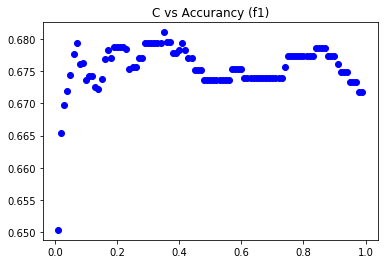

In [25]:
plt.plot(crange,f1_scores, 'bo')
plt.title('C vs Accurancy (f1)')
plt.show()
    

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [26]:
# Train data using TfidfVectorizer
vecTrain = TfidfVectorizer(analyzer='word', stop_words='english' , max_df=0.18)
XTrain=vecTrain.fit_transform(train_data)
trainFeatureNames = vecTrain.get_feature_names()
XDev=vecTrain.transform(dev_data)

# Run Logistic regression on Tfidf transformed data
clf = LogisticRegression(penalty='l2',C=100)
clf.fit(XTrain, train_labels)
YDev=clf.predict(XDev)
YDevProba=clf.predict_proba(XDev)
f1_TfidfVectorizer=metrics.f1_score(dev_labels, YDev, average='weighted')
vocab_size_TfidfVectorizer = len(trainFeatureNames)

In [27]:
def calculateR(probabilities, labels):
    """
    Calculates R for given arrays of probabilities and labels
    For each document R is calculated as 
    maximum predicted probability / predicted probability of the correct label
    
    Args:
        probabilities (numpy.ndarray): M * N 2D array corresponding to 
            probability for each of M data against N labels
        labels (numpy.ndarray): Actual labels         
        
    Returns:
        1D numpy array, R value calculated For each data row 
    """
    R=[max(row)/row[cls] for (row,cls) in zip(probabilities,labels)]
    R=np.array(R)
    return R

R=calculateR(YDevProba, dev_labels)
#print(R)

def printTopRDocuments(data,actual_labels,predicted_label
                       , target_names, R, no_of_documents=3):
    """
    Prints first N documents having largest R values.
    N is determined by patameter no_of_documents
    
    Args:
        data (numpy.ndarray): data array containing documents to be printed
        actual_labels (numpy.ndarray): Actual labels of the data 
            (indices pointing to target_names)
        predicted_label (numpy.ndarray): Labels predicted by classifier 
            (indices pointing to target_names)
        target_names (numpy.ndarray): Master list of labels 
        R (numpy.ndarray): 1D array containing R value for each of the document 
        
    Kwargs:
        no_of_documents (int) : number of documents to be printed
        
    Returns:
        None,
    """
    topDocIndices = np.argpartition(R, -no_of_documents)[-no_of_documents:]
    # reverse sort the indices using array value so the highest R comes first
    topDocIndices = topDocIndices[np.flip(np.argsort(R[topDocIndices]),0)] 

    # Print Documents with largest R
    for i in range(topDocIndices.shape[0]):
        docIndex = topDocIndices[i]
        print('-'*80)
        print('\n{:}. R={:.4f} Predicted Label={} Actual Label={}'.format(
            i+1
            ,R[docIndex]
            ,target_names[predicted_label[docIndex]]
            ,target_names[actual_labels[docIndex]]
            ))
        print('-'*80)
        print(data[docIndex])
    
printTopRDocuments(dev_data, dev_labels, YDev, newsgroups_train.target_names, R, 3)

--------------------------------------------------------------------------------

1. R=1763.3287 Predicted Label=comp.graphics Actual Label=talk.religion.misc
--------------------------------------------------------------------------------
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs

ANSWER:

While shortening the number of features, words very specific to one Label (e.g. ftp is very specific to comp.graphics Label) are given too much weightage in order to compensate the fewer features available to weigh upon. Thus the classifier easily makes mistake if even one such word like ftp in above case appears in any document and wrongly classifies it as comp.graphics.

One way to overcome this issue is to use biagram or trigram of words in addition to single word. This way model would get slightly better understanding of the context of the document and will not be too biased about domain specific single words. The revised model should make fewer mistakes and theoritically may predict wrong label when at least more than one domain specific word appears in another category.

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [28]:
vecTrain = TfidfVectorizer(analyzer='word', stop_words='english'
                           , max_df=400,  ngram_range=(1,2), lowercase=True  )
XTrain=vecTrain.fit_transform(train_data)
trainFeatureNames = vecTrain.get_feature_names()
XDev=vecTrain.transform(dev_data)

clf = LogisticRegression(penalty='l2',C=500, solver='newton-cg')
clf.fit(XTrain, train_labels)
YDev=clf.predict(XDev)

f1_modified=metrics.f1_score(dev_labels, YDev, average='weighted')
vocab_size_modified = len(trainFeatureNames)

print('F1 score changed from earlier {:.5f} to {:.5f}'
      .format(f1_TfidfVectorizer,f1_modified))
print('Vocabulary size from earlier {} to {}'
      .format(vocab_size_TfidfVectorizer,vocab_size_modified))


F1 score changed from earlier 0.78568 to 0.78127
Vocabulary size from earlier 26571 to 189468
